<a href="https://colab.research.google.com/github/ArfianAl/Bullience-ML-Bangkit-Team/blob/main/Model_Violence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
import tensorflow as tf
import matplotlib as mpl
from cycler import cycler
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.linestyle'] = '--'
import re
import string
import nltk
nltk.download('stopwords')
sns.despine()
plt.style.use("fivethirtyeight")
sns.set_style("darkgrid")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


<Figure size 640x480 with 0 Axes>

In [2]:
pip install openpyxl

In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
dv = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/Bangkit/DATASETS GABUNGAN BULLIENCE - Dataset Violence.csv")
dv

,Teks,Label
0,selamat sore saya adalah ibu dari satu anak sa...,Violence
1,mohon bantu pak saya sedang hamil pak diluar n...,Non-Violence
2,saya seorang anak perempuan yang bersuami teta...,Violence
3,jika anak perempuan tidak di beri nafkah orang...,Non-Violence
4,pak saya status pernikahan sudah setahun pisah...,Violence
...,...,...
201,Kami bersama-sama membangun program mentorship...,Non-Violence
202,"Dalam menjalani kehidupan sehari-hari, kami be...",Non-Violence
203,Melibatkan generasi muda dalam kegiatan positi...,Non-Violence
204,Kami aktif dalam kampanye keamanan jalan raya ...,Non-Violence


In [6]:
dv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Teks    206 non-null    object
 1   Label   206 non-null    object
dtypes: object(2)
memory usage: 3.3+ KB


In [7]:
# Checking for null values
dv.isnull().values.any()

False

In [8]:
# Melihat jumlah masing-masing tipe
dv['Label'].value_counts()

Violence        103
Non-Violence    103
Name: Label, dtype: int64

Counter({'Violence': 103, 'Non-Violence': 103})


<Axes: xlabel='Label', ylabel='count'>

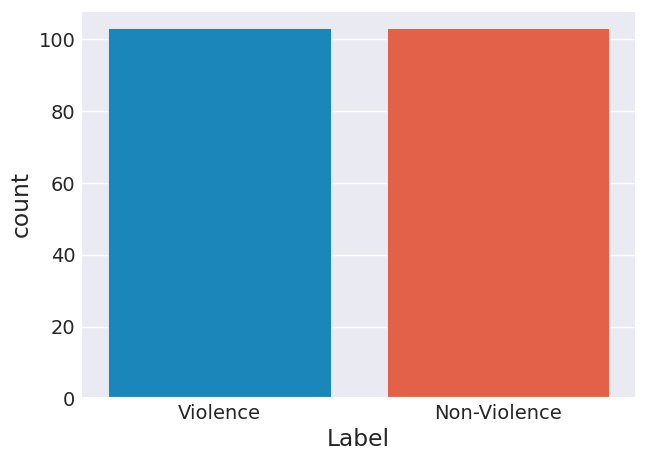

In [10]:
# Distribusi Target
x = dv.Teks
y = dv.Label

from collections import Counter

print(Counter(y))
sns.countplot(x=y)

count    103.000000
mean      22.126214
std       11.981751
min        6.000000
25%       15.000000
50%       21.000000
75%       25.000000
max       94.000000
Name: Length, dtype: float64

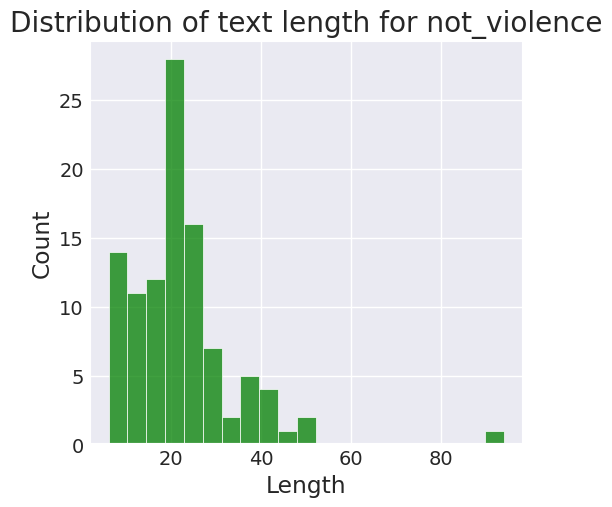

In [11]:
# Melihat statistical description serta histogram panjang teks Non-B
dv["Length"] = dv.Teks.str.split().apply(len)
plt.figure(figsize=(5,5))
sns.histplot(dv[dv["Label"]=="Non-Violence"]['Length'],color="g")
plt.title("Distribution of text length for not_violence")
display(dv.Length[dv["Label"]=="Non-Violence"].describe())

count    103.000000
mean      17.631068
std       13.782619
min        4.000000
25%        8.500000
50%       14.000000
75%       20.000000
max       77.000000
Name: Length, dtype: float64

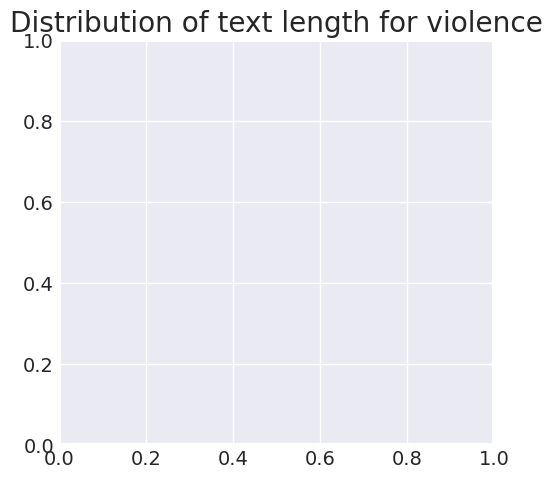

In [12]:
# Melihat statistical description serta histogram panjang teks B
dv["Length"] = dv.Teks.str.split().apply(len)
plt.figure(figsize=(5,5))
sns.histplot(dv[dv["Label"]=="violence"]['Length'],color="r")
plt.title("Distribution of text length for violence")
display(dv.Length[dv["Label"]=="Violence"].describe())

In [15]:
# variabel untuk kolom teks
texts = dv.Teks
print(texts.head())

0    selamat sore saya adalah ibu dari satu anak sa...
1    mohon bantu pak saya sedang hamil pak diluar n...
2    saya seorang anak perempuan yang bersuami teta...
3    jika anak perempuan tidak di beri nafkah orang...
4    pak saya status pernikahan sudah setahun pisah...
Name: Teks, dtype: object


In [16]:
# Case Folding
# gunakan fungsi series.str.lower() pada Pandas
texts = texts.str.lower()

print(texts.head())

0    selamat sore saya adalah ibu dari satu anak sa...
1    mohon bantu pak saya sedang hamil pak diluar n...
2    saya seorang anak perempuan yang bersuami teta...
3    jika anak perempuan tidak di beri nafkah orang...
4    pak saya status pernikahan sudah setahun pisah...
Name: Teks, dtype: object


In [17]:
def remove_special_signs(text):
    # remove tab, new line, ans back slice
    text = text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"")
    # remove non ASCII (emoticon, chinese word, .etc)
    text = text.encode('ascii', 'replace').decode('ascii')
    # remove mention, link, hashtag
    text = ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())
    # remove incomplete URL
    return text.replace("http://", " ").replace("https://", " ")

texts = texts.apply(remove_special_signs)
print(texts.head())

0    selamat sore saya adalah ibu dari satu anak sa...
1    mohon bantu pak saya sedang hamil pak diluar n...
2    saya seorang anak perempuan yang bersuami teta...
3    jika anak perempuan tidak di beri nafkah orang...
4    pak saya status pernikahan sudah setahun pisah...
Name: Teks, dtype: object


In [18]:
#remove number
def remove_number(text):
    return  re.sub(r"\d+", "", text)

texts = texts.apply(remove_number)
texts.head(5)

0    selamat sore saya adalah ibu dari satu anak sa...
1    mohon bantu pak saya sedang hamil pak diluar n...
2    saya seorang anak perempuan yang bersuami teta...
3    jika anak perempuan tidak di beri nafkah orang...
4    pak saya status pernikahan sudah setahun pisah...
Name: Teks, dtype: object

In [19]:
# remove punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans("","",string.punctuation))

texts = texts.apply(remove_punctuation)
texts.head(5)

0    selamat sore saya adalah ibu dari satu anak sa...
1    mohon bantu pak saya sedang hamil pak diluar n...
2    saya seorang anak perempuan yang bersuami teta...
3    jika anak perempuan tidak di beri nafkah orang...
4    pak saya status pernikahan sudah setahun pisah...
Name: Teks, dtype: object

In [20]:
#remove whitespace leading & trailing
def remove_whitespace_LT(text):
    return text.strip()

texts = texts.apply(remove_whitespace_LT)
print(texts.head())

0    selamat sore saya adalah ibu dari satu anak sa...
1    mohon bantu pak saya sedang hamil pak diluar n...
2    saya seorang anak perempuan yang bersuami teta...
3    jika anak perempuan tidak di beri nafkah orang...
4    pak saya status pernikahan sudah setahun pisah...
Name: Teks, dtype: object


In [21]:
# remove multiple whitespace into single whitespace
def remove_whitespace_multiple(text):
    return re.sub('\s+',' ',text)

texts = texts.apply(remove_whitespace_multiple)
print(texts.head())

0    selamat sore saya adalah ibu dari satu anak sa...
1    mohon bantu pak saya sedang hamil pak diluar n...
2    saya seorang anak perempuan yang bersuami teta...
3    jika anak perempuan tidak di beri nafkah orang...
4    pak saya status pernikahan sudah setahun pisah...
Name: Teks, dtype: object


In [22]:
# remove single char
def remove_singl_char(text):
    return re.sub(r"\b[a-zA-Z]\b", "", text)

texts = texts.apply(remove_singl_char)
print(texts.head())

0    selamat sore saya adalah ibu dari satu anak sa...
1    mohon bantu pak saya sedang hamil pak diluar n...
2    saya seorang anak perempuan yang bersuami teta...
3    jika anak perempuan tidak di beri nafkah orang...
4    pak saya status pernikahan sudah setahun pisah...
Name: Teks, dtype: object


In [23]:
# Filtering - Stopword Removal
from nltk.corpus import stopwords
# Get Indonesian stopwords
list_stopwords = stopwords.words('indonesian')

# append additional stopword
list_stopwords.extend(["yg", "dg", "rt", "dgn", "ny", "d", 'klo',
                       'kalo', 'amp', 'biar', 'bikin', 'bilang',
                       'gak', 'ga', 'krn', 'nya', 'nih', 'sih',
                       'si', 'tau', 'tdk', 'tuh', 'utk', 'ya',
                       'jd', 'jgn', 'sdh', 'aja',
                       'nyg', 'hehe', 'pen', 'nan', 'loh',
                       '&amp', 'yah',])

# read txt stopword using pandas
csv_stopword = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/Bangkit/stopwordsID.csv")

# convert stopword string to list & append additional stopword
list_stopwords.extend(csv_stopword)

# convert list to dictionary
list_stopwords = set(list_stopwords)

#remove stopword pada list token
def stopwords_removal(words):
    return [word for word in words if word not in list_stopwords]

texts = texts.apply(stopwords_removal)


print(texts.head())

0    [s, e, l, a, m, a, t,  , s, o, r, e,  , s, a, ...
1    [m, o, h, o, n,  , b, a, n, t, u,  , p, a, k, ...
2    [s, a, y, a,  , s, e, o, r, a, n, g,  , a, n, ...
3    [j, i, k, a,  , a, n, a, k,  , p, e, r, e, m, ...
4    [p, a, k,  , s, a, y, a,  , s, t, a, t, u, s, ...
Name: Teks, dtype: object


In [25]:
def normalize_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    stop_words = set(stopwords.words('indonesian'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

dv['Teks'] = dv['Teks'].apply(normalize_text)

In [26]:
# convert the categorical values to numeric using the factorize() method. This returns an array of numeric values and an Index of categories.
# Inisialisasi variabel target
y = dv["Label"]
#mengubah y menjadi integer
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y = to_categorical(y)
print(y)

[[0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 

In [28]:
# Menghitung jumlah value integer sentimen
dv["Label"].value_counts()

Violence        103
Non-Violence    103
Name: Label, dtype: int64

In [52]:
# replace label pada dataset
dv.Label.replace("Violence", 0 , inplace = True)
dv.Label.replace("Non-Violence", 1 , inplace = True)
dv.head(10)

,Teks,Label,Length
0,selamat sore anak janda mantan suami menganiay...,0,27
1,mohon bantu hamil diluar nikah anak kembar pac...,1,42
2,anak perempuan bersuami orang tua campur ayah ...,0,27
3,anak perempuan nafkah orang tua nya lakukan an...,1,24
4,status pernikahan setahun pisah ranjang pernik...,0,77
5,ayah melarang anak bertemu nya dilarang merawa...,1,21
6,bercerai tujuh ngga nafkah anak kemana bantuan,1,17
7,anak anak ditelantarkan perantauan suami bawa ...,0,62
8,lakukan perlindungan perempuan suami menyiksa ...,0,14
9,tolong perlindungan pencemaran nama anak ancam...,0,20


In [53]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import LabelEncoder
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [54]:
def normalize_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

dv['Teks'] = dv['Teks'].apply(normalize_text)

In [65]:
# Tokenisasi dan stemming
def tokenize_and_stem(text):
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    stemmer = PorterStemmer()
    stems = [stemmer.stem(t) for t in tokens]
    return stems

# Contoh pemisahan dataset menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(dv['Teks'], dv['Label'], test_size=0.2, random_state=42)

max_words = 100  # Jumlah kata unik yang akan diambil
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

max_sequence_length = max(len(seq) for seq in X_train_sequences)
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length, padding='post', truncating='post')

stemmer = PorterStemmer()
X_train_stemmed = [' '.join([stemmer.stem(word) for word in text.split()]) for text in X_train]
X_test_stemmed = [' '.join([stemmer.stem(word) for word in text.split()]) for text in X_test]


In [66]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=max_words, output_dim=16, input_length=max_sequence_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')

])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 45, 16)            1600      
                                                                 
 flatten_3 (Flatten)         (None, 720)               0         
                                                                 
 dense_18 (Dense)            (None, 64)                46144     
                                                                 
 dense_19 (Dense)            (None, 1)                 65        
                                                                 
Total params: 47809 (186.75 KB)
Trainable params: 47809 (186.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [62]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [63]:
model.fit(X_train_padded, y_train, epochs=10, validation_data=(X_test_padded, y_test))

Epoch 1/10
6/6 [==============================] - 1s 42ms/step - loss: 0.6939 - accuracy: 0.4817 - val_loss: 0.6920 - val_accuracy: 0.5238
Epoch 2/10
6/6 [==============================] - 0s 10ms/step - loss: 0.6820 - accuracy: 0.6951 - val_loss: 0.6913 - val_accuracy: 0.4048
Epoch 3/10
6/6 [==============================] - 0s 10ms/step - loss: 0.6715 - accuracy: 0.6890 - val_loss: 0.6861 - val_accuracy: 0.5238
Epoch 4/10
6/6 [==============================] - 0s 12ms/step - loss: 0.6572 - accuracy: 0.8110 - val_loss: 0.6778 - val_accuracy: 0.7143
Epoch 5/10
6/6 [==============================] - 0s 9ms/step - loss: 0.6367 - accuracy: 0.8659 - val_loss: 0.6666 - val_accuracy: 0.7619
Epoch 6/10
6/6 [==============================] - 0s 12ms/step - loss: 0.6067 - accuracy: 0.8780 - val_loss: 0.6453 - val_accuracy: 0.7381
Epoch 7/10
6/6 [==============================] - 0s 14ms/step - loss: 0.5680 - accuracy: 0.8720 - val_loss: 0.6258 - val_accuracy: 0.7381
Epoch 8/10
6/6 [============

In [64]:
model.fit(X_train_padded, y_train, epochs=20, validation_data=(X_test_padded, y_test))

Epoch 1/20
6/6 [==============================] - 0s 21ms/step - loss: 0.3312 - accuracy: 0.9024 - val_loss: 0.5145 - val_accuracy: 0.7619
Epoch 2/20
6/6 [==============================] - 0s 11ms/step - loss: 0.2721 - accuracy: 0.9207 - val_loss: 0.4917 - val_accuracy: 0.8571
Epoch 3/20
6/6 [==============================] - 0s 12ms/step - loss: 0.2210 - accuracy: 0.9451 - val_loss: 0.4663 - val_accuracy: 0.8095
Epoch 4/20
6/6 [==============================] - 0s 9ms/step - loss: 0.1729 - accuracy: 0.9634 - val_loss: 0.4456 - val_accuracy: 0.8333
Epoch 5/20
6/6 [==============================] - 0s 9ms/step - loss: 0.1388 - accuracy: 0.9817 - val_loss: 0.4299 - val_accuracy: 0.8571
Epoch 6/20
6/6 [==============================] - 0s 12ms/step - loss: 0.1099 - accuracy: 0.9878 - val_loss: 0.4164 - val_accuracy: 0.8333
Epoch 7/20
6/6 [==============================] - 0s 9ms/step - loss: 0.0863 - accuracy: 0.9878 - val_loss: 0.4049 - val_accuracy: 0.8571
Epoch 8/20
6/6 [==============